In [1]:
validation_set_size = 1024
batch_size = 512
IMAGE_SIZE = 128
NUMBER_OF_PARTICLES = 1 #number of extra particles in image will be round(poi(NUMBER_OF_PARTICLES))
Z_RANGE = 30
save_model_path = "/content/drive/My Drive/rough_networks_feb16/"

In [2]:
"""Import everything we need and check gpu"""
%matplotlib inline

already_installed = !pip list -v | grep deeptrack
if not already_installed:
    !pip install deeptrack==0.11.3

import os
import numpy as np
import matplotlib.pyplot as plt
import deeptrack as dt
from matplotlib import colors
from cycler import cycler
from google.colab import drive

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)    
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

     |████████████████████████████████| 80 kB 5.0 MB/s 
     |████████████████████████████████| 1.1 MB 19.9 MB/s 
     |████████████████████████████████| 462 kB 48.6 MB/s 
Fri Feb 18 12:08:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/

In [3]:
def save_models(models):
    drive.mount('/content/drive')
    for i, model in enumerate(models):
        model.save(save_model_path+f"model{i}")


In [4]:
"""Define optics"""
particle = dt.MieSphere(
    position=lambda: (IMAGE_SIZE) * np.random.rand(2),
    z=lambda: -(300+Z_RANGE//2)//2 + np.random.random()*(300+Z_RANGE//2),
    radius=lambda: 1.5e-7 + 3e-7 * np.random.rand() ,
    refractive_index=lambda: np.random.uniform(0, 0.15) + 1.45,
    L=8,
    position_unit="pixel",
)

particle_middle = dt.MieSphere(
    position=lambda: (IMAGE_SIZE//2, IMAGE_SIZE//2),
    z=lambda: -Z_RANGE//2 + np.random.random() * Z_RANGE,
    radius=lambda: 1.5e-7 + 3e-7 * np.random.rand() ,
    refractive_index=lambda: np.random.uniform(0, 0.15) + 1.45,
    L=8,
    position_unit="pixel",
)

HC = dt.HorizontalComa(coefficient=lambda c1: c1, c1=0 + np.random.randn() * 0.05)
VC = dt.VerticalComa(coefficient=lambda c2:c2, c2=0 + np.random.randn() * 0.05)

def crop(pupil_radius):
    def inner(image):
        x = np.arange(image.shape[0]) - image.shape[0] / 2
        y = np.arange(image.shape[1]) - image.shape[1] / 2
        X, Y = np.meshgrid(x, y)
        image[X ** 2 + Y ** 2 > pupil_radius ** 2] = 0
        return image
    return inner
CROP = dt.Lambda(crop, pupil_radius=IMAGE_SIZE//6)

optics = dt.Brightfield(
    NA=1.3,
    resolution=1.13e-6,
    wavelength=525e-9,
    polarization_angle=lambda: np.random.rand() * 2 * np.pi,
    magnification=10,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
    padding=(64,) * 4,
    return_field=True,
    pupil=HC+VC + CROP,
)

real_noise = dt.Gaussian(
    mu=0, 
    sigma=lambda: 0.035 + np.random.rand() * 0.01,
)

noise = real_noise + dt.Gaussian(
    mu=0, 
    sigma=lambda: 0.035j + np.random.rand() * 0.01j,
    real_sigma=real_noise.sigma
)

gradient = dt.IlluminationGradient(
    gradient=lambda: np.random.randn(2) * 5e-5,
)

def func():
    def inner(image):
        image = (image - 1)
        output = np.zeros((*image.shape[:2], 2))
        output[..., 0:1] = np.real(image)
        output[..., 1:2] = np.imag(image)
        return output
    return inner

def normalization_func():
    def inner(image):
        output = np.zeros((*image.shape[:2], 2))
        output[:,:,0] = image[:,:,0] - np.min(image[:,:,0])
        output[:,:,1] = image[:,:,1] - np.min(image[:,:,1])
        output[:,:,0] = image[:,:,0] / np.max(image[:,:,0])
        output[:,:,1] = image[:,:,1] / np.max(image[:,:,1])
        return output
    return inner

def add_abs():
    def inner(image):
        output = np.zeros((*image.shape[:2], 3))
        output[:,:,0] = image[:,:,0]
        output[:,:,1] = image[:,:,1]
        output[:,:,2] = np.abs(image[:,:,0]+image[:,:,1]*1j)
        return output
    return inner

complex_to_float = dt.Lambda(func)
normalization = dt.Lambda(normalization_func)
add_absolute = dt.Lambda(add_abs)

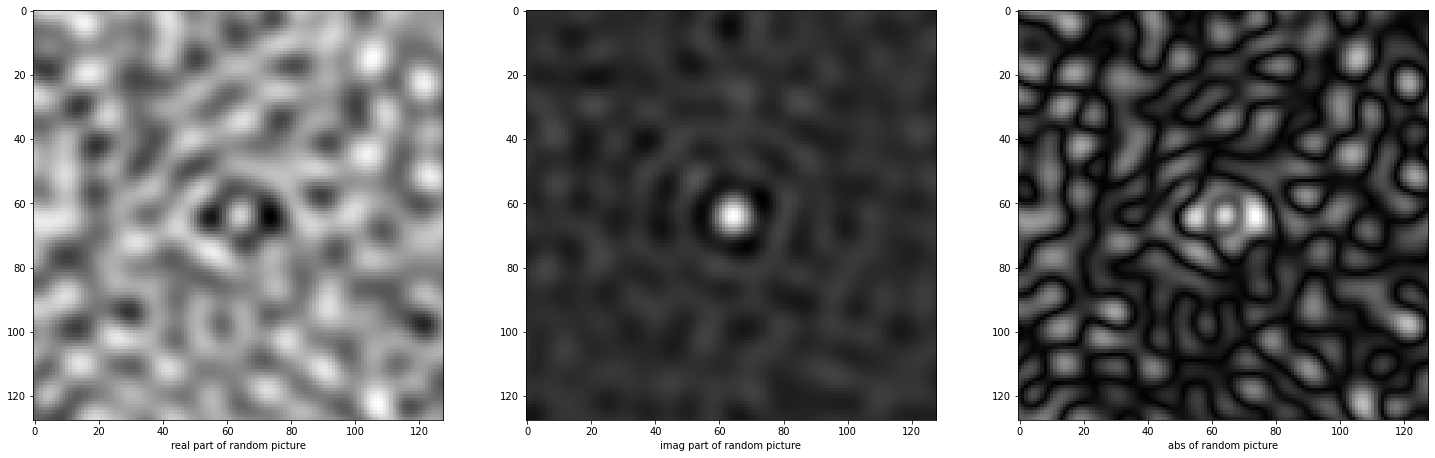

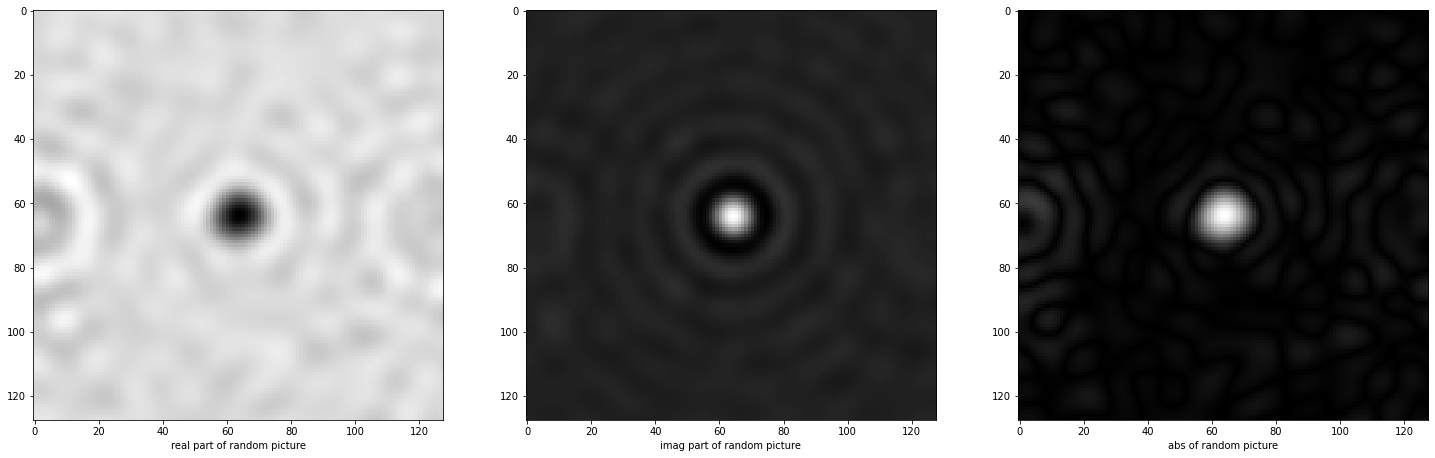

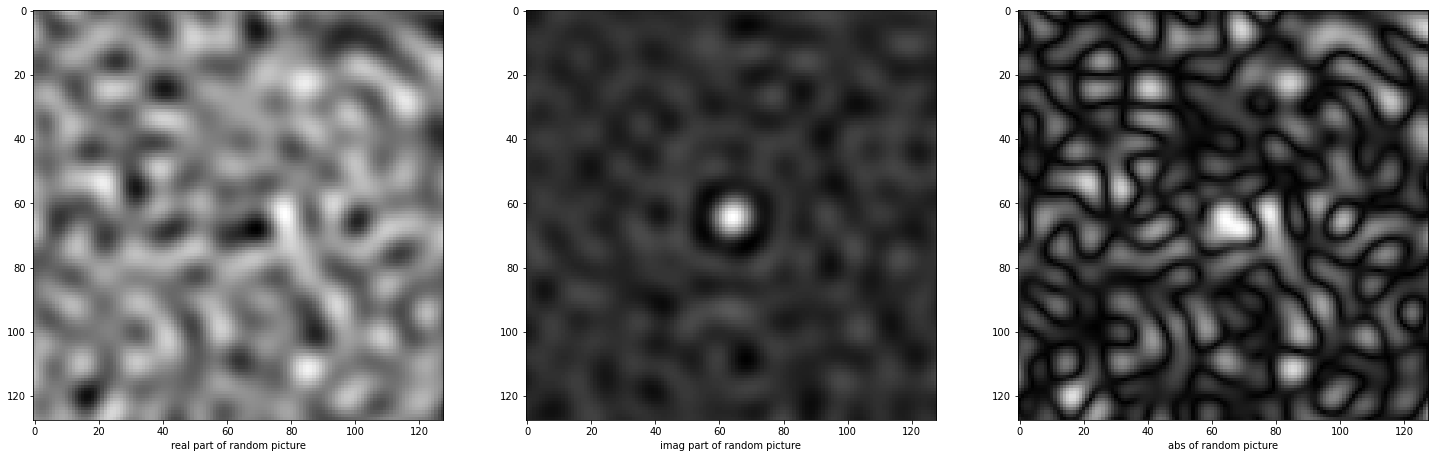

In [16]:
"""Plotting one random image and creating the dataset"""
def particles(particle):
    return particle ** max(0, round(np.random.poisson(lam=NUMBER_OF_PARTICLES)))
                                              

for _ in range(3):
    dataset = optics(particle_middle + particles(particle) + noise + gradient) + complex_to_float + normalization + add_absolute
    dataset = dt.FlipLR(dt.FlipUD(dt.FlipDiagonal(dataset)))
    test_image = dataset.update().resolve()

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25,8))
    ax1.imshow(test_image[:,:,0], cmap='gray')
    ax1.set_xlabel("real part of random picture")
    ax2.imshow(test_image[:,:,1], cmap='gray')
    ax2.set_xlabel("imag part of random picture")
    ax3.imshow(test_image[:,:,2], cmap='gray')
    ax3.set_xlabel("abs of random picture")
    plt.show()

In [6]:
"""get_label returns the z position of the middle particle, but normalized to [0,1]"""
def get_label(image):
    return np.array([image.get_property("z")])

In [ ]:
from keras import layers, models, datasets
from tensorflow import keras
"Skapar modeller!"
models_to_train = []

for _ in range(5):
    model = models.Sequential()
    model.add(layers.Conv2D(16, 7, activation='relu', strides=(5,5), input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
    model.add(layers.Conv2D(32, 7, activation='relu', strides=(4,4)))
    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.totalhistory = {"val_loss":[], "loss":[]}
    model.specs=""
    model.summary()
    models_to_train.append(model)


In [8]:
"""Helper functions to visualize progress during training."""

def save_progress(h, validation_set, validation_labels, model, plot=True):
    model.totalhistory["val_loss"].extend(h.history["val_loss"])
    model.totalhistory["loss"].extend(h.history["loss"])
                
    if plot:
        validation_predictions = model.predict(np.array(validation_set))
        std = np.std(validation_predictions-np.array(validation_labels))
        mean = np.mean(validation_predictions-np.array(validation_labels))
        model.stats = {"sigma":np.round(std, decimals=3), "mu":np.round(mean, decimals=3)}
        print(model.stats)
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30,8))

        ax1.plot(model.totalhistory["val_loss"], 'g', label="validation loss")
        ax1.plot(model.totalhistory["loss"], 'b', label="training loss")
        ax1.set_xlabel("Epoch")
        ax1.set_yscale('log')
        ax1.legend()

        ax2.scatter(np.array(validation_predictions), np.array(validation_labels))
        ax2.plot(np.linspace(-Z_RANGE/2,Z_RANGE/2),np.linspace(-Z_RANGE/2,Z_RANGE/2),'k')
        ax2.set_xlabel("predicted z")
        ax2.set_ylabel("actual z")

        ax3.hist(np.array((validation_predictions-np.array(validation_labels))), bins=list(np.linspace(-Z_RANGE/2,Z_RANGE/2,10*Z_RANGE)))
        ax3.set_xlabel("Pixlar från faktiskt värde")

        index = np.random.randint(validation_set_size)
        real_image = np.sqrt( validation_set[index][:,:,0]**2 + validation_set[index][:,:,1]**2)
        ax4.imshow(real_image, cmap='gray')
        ax4.set_xlabel("Magnituden hos en slumpmässig bild.")

        plt.show()

def plot_together(models):
    cc = (cycler(color=list('bgrcmykbgrcmykbgrcmykbgrcmyk')) +
      cycler(linestyle=['-','-','-','-','-','-','-','--','--','--','--','--','--','--','-.','-.','-.','-.','-.','-.','-.',':',':',':',':',':',':',':']))
    
    fig, ax = plt.subplots(1,1,figsize=(15,15))
    ax.set_prop_cycle(cc)
    for i, model in enumerate(models):
        ax.plot(moving_average(model.totalhistory["val_loss"], min(100, len(model.totalhistory["val_loss"])//4)), label=f"Model {i}, {model.specs}")
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Validation loss")
        ax.set_yscale("log")
        ax.legend()

    ax.grid(True)
    plt.show()

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def print_std(models, n):
    mean_validation_predictions = np.mean([model.predict(np.array(validation_set)) for model in models[:n]], axis=0)
    diffs = np.array((mean_validation_predictions-np.array(validation_labels)))
    print(f"sigma and mu for {n} best models: {np.std(diffs)}, {np.mean(diffs)}")
    plt.hist(np.array((mean_validation_predictions-np.array(validation_labels))), bins=list(np.linspace(-Z_RANGE/2,Z_RANGE/2,10*Z_RANGE)))
    plt.show()

In [9]:
"""Create the validation set"""
validation_set = [dataset.update().resolve() for _ in range(validation_set_size)]
validation_labels = [get_label(image) for image in validation_set]

Generating 527 / 512 samples before starting training

{'sigma': 1.061, 'mu': 0.093}


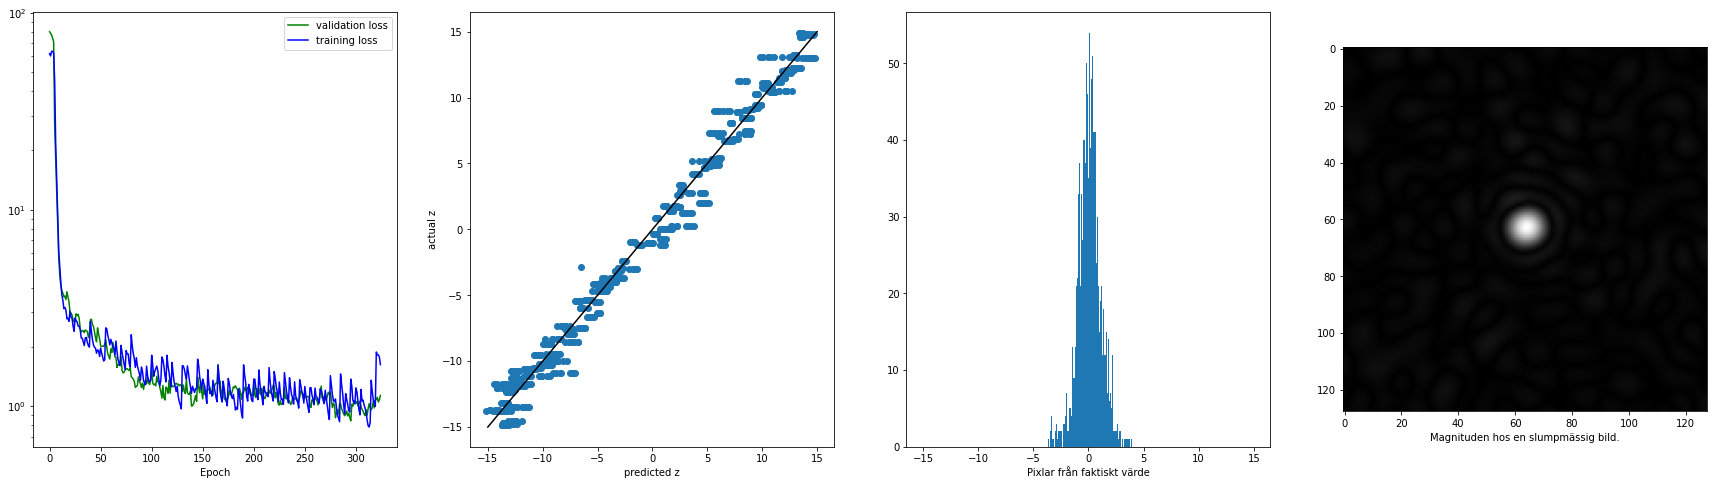


{'sigma': 1.075, 'mu': -0.008}


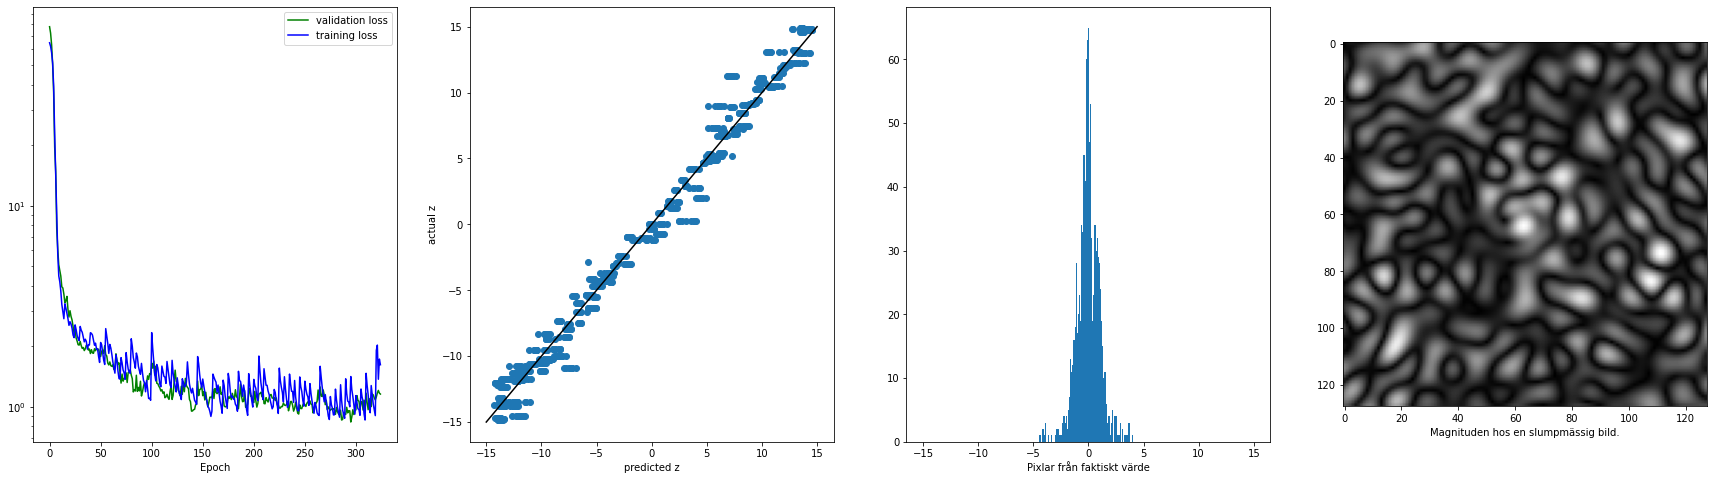


{'sigma': 1.021, 'mu': 0.059}


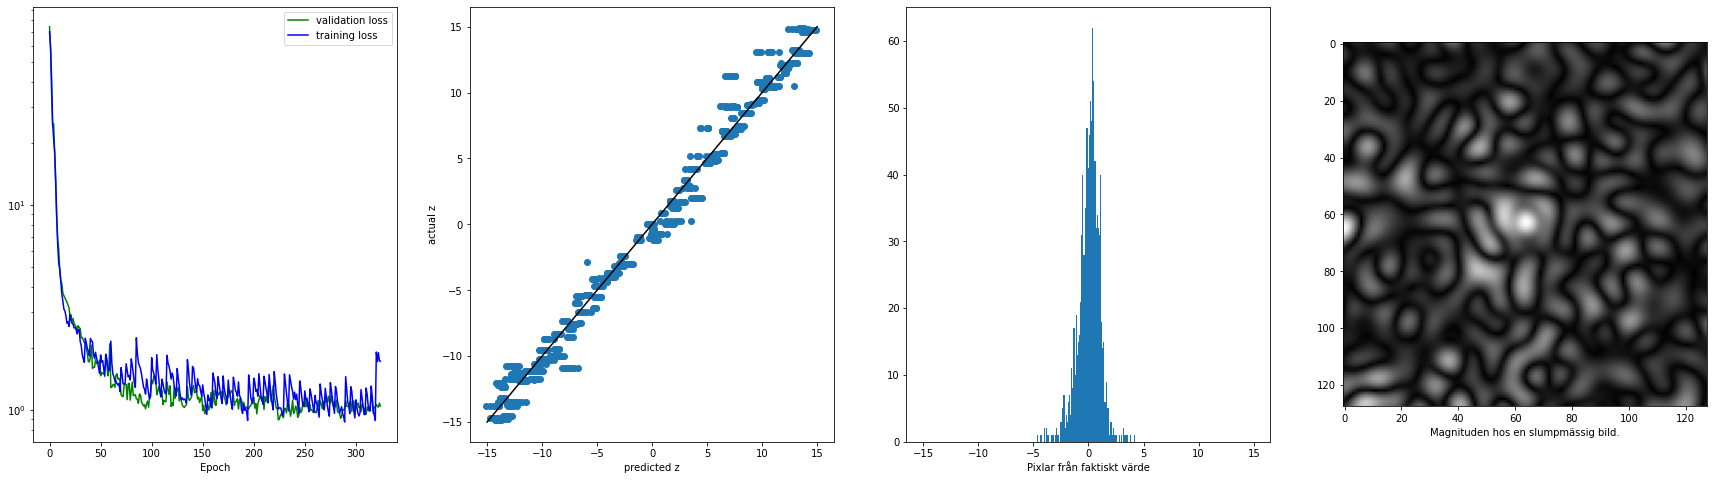


{'sigma': 1.068, 'mu': 0.131}


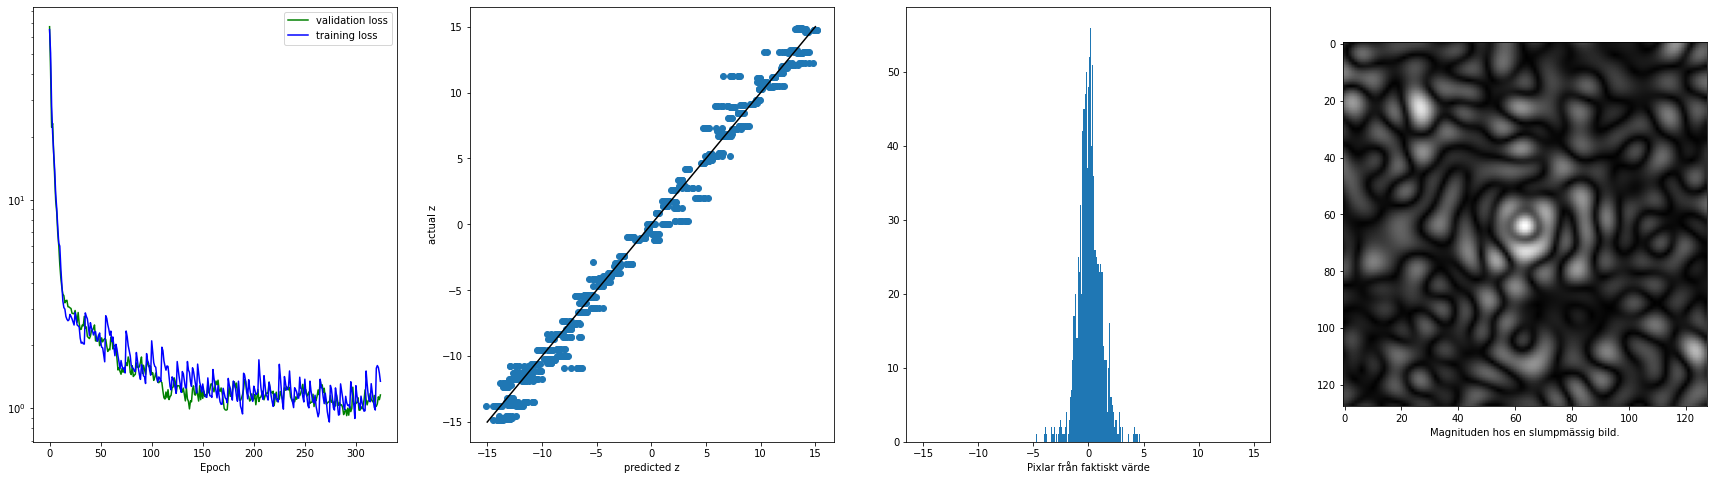


{'sigma': 1.075, 'mu': -0.033}


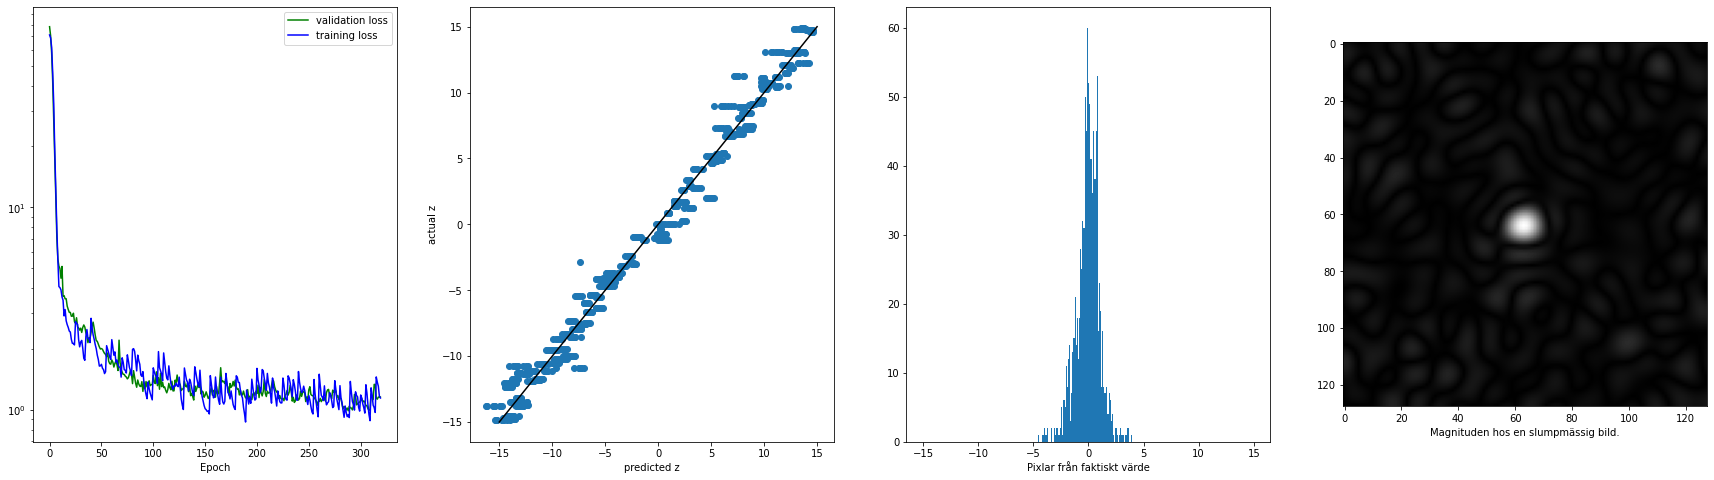

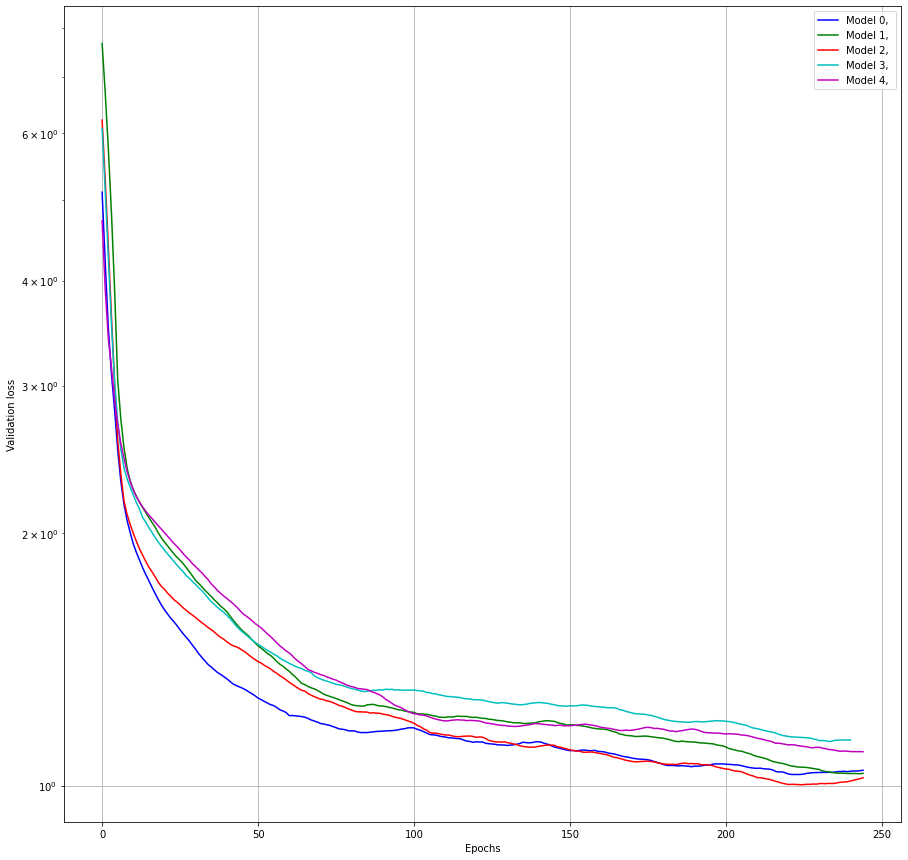

sigma and mu for 5 best models: 0.9965433870812523, 0.048408213987297485


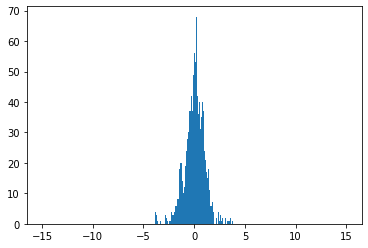

Generating 2424 / 512 samples before starting training


KeyboardInterrupt: ignored

In [17]:
"""Training all the models"""
generator = dt.generators.ContinuousGenerator(
    dataset,
    get_label,
    min_data_size=batch_size,
    max_data_size=batch_size*10,
    batch_size=batch_size,
)

for _ in range(150):
    with generator:
        for i, model in enumerate(models_to_train):
            h = model.fit(
                generator,
                validation_data=(
                    np.array(validation_set), 
                    np.array(validation_labels)
                ),
                epochs=5,
                verbose=0,
            )
            print(model.specs)
            save_progress(h, validation_set, validation_labels, model, plot=True)
        models_to_train.sort(key=lambda x: x.totalhistory["val_loss"][-1])
        plot_together(models_to_train)
        print_std(models_to_train, 5)

In [ ]:
"""Save models"""
save_models(models_to_train[:15])

In [ ]:
for _ in range(100):
    print(max(0, round(np.random.poisson(lam=0.5))))

In [ ]:
#@title
import keras

def visualize_feature_maps(model, image_of_particle, SUBPLOT_SIZE=6, SUBPLOT_WIDTH=8):
    """
        # Parameters:
        model: The keras model whose featuremaps are to be visualized.
        image_of_particles: The image that should be visualized.
        SUBPLOT_SIZE: The size of each individual subplot.
        SUBPLOT_WIDTH: The number of subplots to lign up horizontally. Prefferably a multiple of two.
    """
    # Plotting the two input channels (Im() and Re())
    input_fig, ax = plt.subplots(1, 2)

    ax[0].imshow(image_of_particle[:, :, 0], cmap='gray')
    ax[0].set_title("Real (?) part")
    ax[0].set_xticks([])
    ax[0].set_yticks([])

    ax[1].imshow(image_of_particle[:, :, 1], cmap='gray')
    ax[1].set_title("Im (?) part")
    ax[1].set_xticks([])
    ax[1].set_yticks([])

    plt.show()

    # Plotting all outputs from convolutional layer, each layer is given its own figure
    IMAGE_SIZE = image_of_particle.shape[0]
    img = image_of_particle.reshape(1, IMAGE_SIZE, IMAGE_SIZE, 2) # Reshape needed for model prediction input

    for layer in model.layers:
        if 'conv' not in layer.name: # Ignoring non-convolutional layers
            continue
        
        NUMBER_OF_OUTPUTS = layer.output.shape[3] # Total number of subplots
        SUBPLOT_HEIGHT = NUMBER_OF_OUTPUTS // SUBPLOT_WIDTH # Number of rows needed

        # Create a submodel equal to the original model but cut off at the current layer.
        submodel = keras.Model(inputs=model.inputs, outputs=layer.output)

        # Generate prediction outputs for the submodel
        feature_maps = submodel.predict(img)

        # Plotting all the outputs in a square figure

        output_number = 0
        fig, ax = plt.subplots(SUBPLOT_HEIGHT, SUBPLOT_WIDTH, figsize=(SUBPLOT_WIDTH * SUBPLOT_SIZE, SUBPLOT_HEIGHT * SUBPLOT_SIZE))
        fig.suptitle("Output of layer: " + layer.name)
        ax = ax.flatten()

        for output_number, axis in zip(range(len(ax)), ax):
            axis.imshow(feature_maps[0, :, :, output_number], cmap='gray')
            ax[output_number].set_xticks([])
            ax[output_number].set_yticks([])
                
        plt.show()

model=models[0]
image_of_particle=validation_set[0]
visualize_feature_maps(model, image_of_particle, SUBPLOT_SIZE=6, SUBPLOT_WIDTH=8)